In [38]:
import numpy as np
import pandas as pd
from scipy import stats

from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis
from scipy.stats import norm

import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

# from itertools import groupby
# from operator import itemgetter
import time

In [30]:

class OdorPredictor:
    def __init__(self, fitted_p_heatmap, xedges, yedges, fdf, fdf_nowhiff, distance_threshold=4, rows_per_second=200, base_odor_level=0.58):
        self.fitted_p_heatmap = fitted_p_heatmap
        self.xedges = xedges
        self.yedges = yedges
        self.distance_threshold = distance_threshold
        self.rows_per_second = rows_per_second
        self.base_odor_level = base_odor_level
        self.initialize_data(fdf, fdf_nowhiff)

    def initialize_data(self, fdf, fdf_nowhiff):
        # Extract necessary data as arrays for faster access
        self.whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
        self.nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
        self.whiff_means = fdf.mean_concentration.values
        self.whiff_stds = fdf.std_whiff.values
        self.whiff_duration = fdf.length_of_encounter.values
        self.nowhiff_means = fdf_nowhiff.wc_nowhiff.values
        self.nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

    def predict_whiff_from_probability(self, x, y):
        x_bin = np.digitize(x, self.xedges) - 1
        y_bin = np.digitize(y, self.yedges) - 1
        if x_bin < 0 or x_bin >= self.fitted_p_heatmap.shape[0] or y_bin < 0 or y_bin >= self.fitted_p_heatmap.shape[1]:
            return False, 0
        whiff_prob = self.fitted_p_heatmap[x_bin, y_bin]
        return np.random.rand() < whiff_prob, whiff_prob

    @staticmethod
    def moving_average(data, window_size=5):
        # Adjust moving average to keep the same length as input data
        return np.convolve(data, np.ones(window_size)/window_size, mode='same')

    def predict_odor_concentration(self, x, y):
        # Convert DataFrame columns to NumPy arrays
        df_test = pd.DataFrame({'distance_along_streakline': x, 'nearest_from_streakline': y})
        odor_concentration_samples = np.full(len(df_test), self.base_odor_level)
        whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

        test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
        distances = cdist(test_locations, self.whiff_locations)
        distances_nowhiff = cdist(test_locations, self.nowhiff_locations)

        # Process whiff and no-whiff regions
        odor_concentration_samples, whiff_prediction_samples = self.process_whiff_regions(
            distances, odor_concentration_samples, whiff_prediction_samples, test_locations
        )
        odor_concentration_samples = self.process_no_whiff_regions(
            distances_nowhiff, odor_concentration_samples
        )

        # Return results as DataFrame
        df_test['predicted_odor'] = odor_concentration_samples
        df_test['whiff_predicted'] = whiff_prediction_samples
        return df_test

    def process_whiff_regions(self, distances, odor_concentration_samples, whiff_prediction_samples, test_locations):
        for i, (dist_along, nearest_from) in enumerate(test_locations):
            whiff_predicted, _ = self.predict_whiff_from_probability(dist_along, nearest_from)
            if whiff_predicted and np.min(distances[i]) <= self.distance_threshold:
                nearest_whiff_idx = np.argmin(distances[i])
                mean_concentration = self.whiff_means[nearest_whiff_idx]
                std_dev_whiff = self.whiff_stds[nearest_whiff_idx]
                duration = int(self.whiff_duration[nearest_whiff_idx] * self.rows_per_second)
                rows_to_fill = min(duration, len(odor_concentration_samples) - i)

                generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
                generated_concentrations = np.clip(generated_concentrations, 4, 10.2)
                odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
                whiff_prediction_samples[i:i + rows_to_fill] = 1
        return odor_concentration_samples, whiff_prediction_samples

    def process_no_whiff_regions(self, distances_nowhiff, odor_concentration_samples):
        i = 0
        while i < len(odor_concentration_samples):
            if odor_concentration_samples[i] == self.base_odor_level:
                nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
                no_whiff_mean = self.nowhiff_means[nearest_no_whiff_idx]
                no_whiff_std = self.nowhiff_wsd[nearest_no_whiff_idx]

                start = i
                while i < len(odor_concentration_samples) and odor_concentration_samples[i] == self.base_odor_level:
                    i += 1
                end = i

                no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
                no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)
                
                # Check if moving average should be applied
                if end - start >= 5:  # Apply only if length >= window size
                    smoothed_concentrations = self.moving_average(no_whiff_concentrations, window_size=5)
                    odor_concentration_samples[start:end] = smoothed_concentrations[:end - start]
                else:
                    odor_concentration_samples[start:end] = no_whiff_concentrations
            else:
                i += 1
        return odor_concentration_samples

if __name__ == "__main__":
    t = time.time()
    dirname = '../data/simulator/hws/'
    hmap_data = np.load(str(dirname) + "hmap_with_edges.npz")
    
    predictor = OdorPredictor(
        fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
        xedges=hmap_data['xedges'],
        yedges=hmap_data['yedges'],
        fdf=pd.read_hdf(str(dirname) + 'whiff.h5'),
        fdf_nowhiff=pd.read_hdf(str(dirname) + 'nowhiff.h5')
    )
    
    df = pd.read_hdf(str(dirname) + 'hwsDesert.h5')
    df_test = df[10000:].reset_index(drop=True)
    x = df_test.distance_along_streakline.values
    y = df_test.nearest_from_streakline.values

    pdf = predictor.predict_odor_concentration(x, y)

    print(time.time()-t)

10.194443464279175


In [31]:
df_test['predicted_odor']=pdf.predicted_odor
df_test['whiff_predicted']=pdf.whiff_predicted

In [32]:
th=4.5
query1 = 'odor>4.5'
new_test_df1=pd.DataFrame()
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>4.5'
new_test_df2=pd.DataFrame()
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)

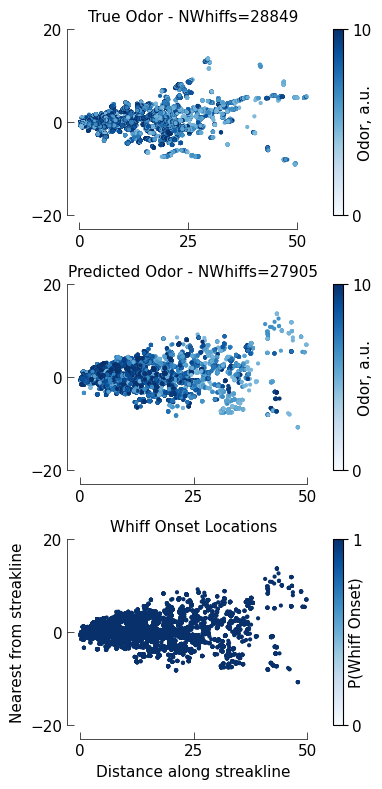

In [33]:
f, ax = plt.subplots(3, 1, figsize=(4, 8))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)
# ylim=(-15,25)

ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
ax[2].set_title('Whiff Onset Locations')
ax[2].set_xlabel('Distance along streakline')
ax[2].set_ylabel('Nearest from streakline')

cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
cb3=plt.colorbar(cax3)

cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-10)
cb3.set_label('P(Whiff Onset)',labelpad=-10)

cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
cb3.set_ticks([0, 1])
for i in range(3):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50],
                            yticks=[-20,0,20],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

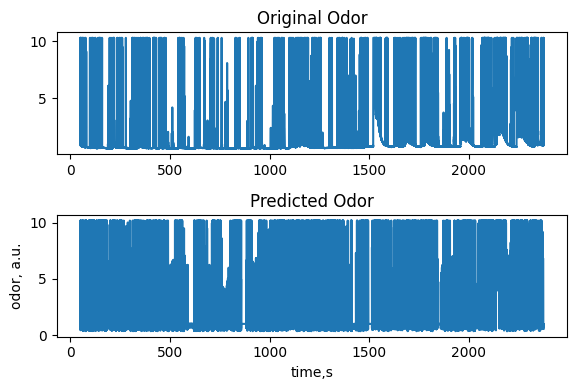

In [34]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
ax1.plot(df_test.time, df_test.odor, label='original')
# plt.plot(df_test.smoothed_odor, label='smoothed')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
# ax2.axhline(4, color = 'r', linestyle = '--')

# limit=(1100,1120)
# limit = (58,65)
# ax1.set_xlim(limit)
# ax2.set_xlim(limit)
# ax2.set_ylim(0,1)

ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
ax1.set_title('Original Odor')
ax2.set_title('Predicted Odor')
f.tight_layout()

/tmp/ipykernel_1345210/2804690337.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  whiff_counts_actual = df_actual.groupby('distance_bin').size()
/tmp/ipykernel_1345210/2804690337.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
/tmp/ipykernel_1345210/2804690337.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  whiff_counts_predicted =

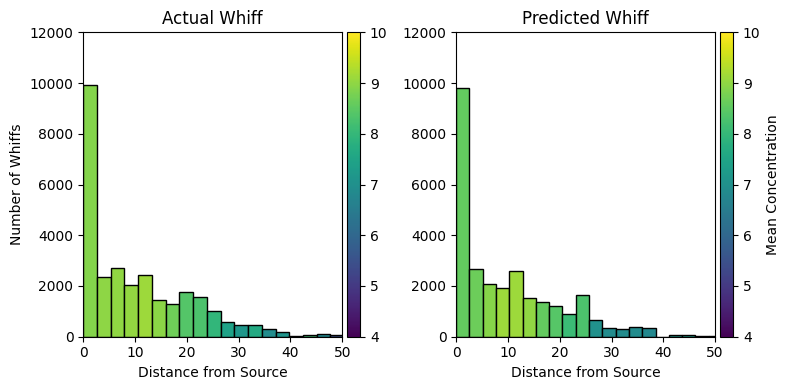

In [35]:
n_bins = 20
ylim = (0,12000)
# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Create the subplots
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)
# cbar_actual.set_label('Mean Concentration')

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('Number of Whiffs')
ax[0].set_title('Actual Whiff')
ax[0].set_ylim(ylim)
ax[0].set_xlim(0,50)
# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
ax[1].set_ylim(ylim)
ax[1].set_xlim(0,50)
f.tight_layout()



### archive

In [28]:
# class OdorPredictor:
#     def __init__(self, fitted_p_heatmap, xedges, yedges, fdf, fdf_nowhiff, distance_threshold=4, rows_per_second=200, base_odor_level=0.58):
#         self.fitted_p_heatmap = fitted_p_heatmap
#         self.xedges = xedges
#         self.yedges = yedges
#         self.fdf = fdf
#         self.fdf_nowhiff = fdf_nowhiff
#         self.distance_threshold = distance_threshold
#         self.rows_per_second = rows_per_second
#         self.base_odor_level = base_odor_level
#         self.initialize_data()

#     def initialize_data(self):
#         # Precompute values for performance
#         self.whiff_locations = self.fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
#         self.nowhiff_locations = self.fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
#         self.whiff_means = self.fdf.mean_concentration.values
#         self.whiff_stds = self.fdf.std_whiff.values
#         self.whiff_duration = self.fdf.length_of_encounter.values
#         self.nowhiff_means = self.fdf_nowhiff.wc_nowhiff.values
#         self.nowhiff_wsd = self.fdf_nowhiff.wsd_nowhiff.values

#     def predict_whiff_from_probability(self, x, y):
#         x_bin = np.digitize(x, self.xedges) - 1
#         y_bin = np.digitize(y, self.yedges) - 1
#         if x_bin < 0 or x_bin >= self.fitted_p_heatmap.shape[0] or y_bin < 0 or y_bin >= self.fitted_p_heatmap.shape[1]:
#             return False, 0
#         whiff_prob = self.fitted_p_heatmap[x_bin, y_bin]
#         return np.random.rand() < whiff_prob, whiff_prob

#     def moving_average(self, data, window_size):
#         if window_size < 1 or len(data) < window_size:
#             return data
#         window = np.ones(int(window_size)) / float(window_size)
#         return np.convolve(data, window, 'same')

#     def predict_odor_concentration(self, x, y):
#         df_test = pd.DataFrame({'distance_along_streakline': x, 'nearest_from_streakline': y})
#         odor_concentration_samples = np.full(len(df_test), self.base_odor_level)
#         whiff_prediction_samples = np.zeros(len(df_test), dtype=int)
        
#         test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
#         distances = cdist(test_locations, self.whiff_locations)
#         distances_nowhiff = cdist(test_locations, self.nowhiff_locations)

#         i = 0
#         while i < len(df_test):
#             dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
#             whiff_predicted, _ = self.predict_whiff_from_probability(dist_along, nearest_from)
#             if whiff_predicted and np.min(distances[i]) <= self.distance_threshold:
#                 nearest_whiff_idx = np.argmin(distances[i])
#                 mean_concentration = self.whiff_means[nearest_whiff_idx]
#                 std_dev_whiff = self.whiff_stds[nearest_whiff_idx]
#                 duration = int(self.whiff_duration[nearest_whiff_idx] * self.rows_per_second)
#                 rows_to_fill = min(duration, len(df_test) - i)

#                 generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
#                 generated_concentrations = np.clip(generated_concentrations, 4, 10.2) ## limit chosen based on PID sensor 
#                 odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
#                 whiff_prediction_samples[i:i + rows_to_fill] = 1
#                 i += rows_to_fill
#             else:
#                 i += 1

#         i = 0
#         while i < len(df_test):
#             if odor_concentration_samples[i] == self.base_odor_level:
#                 nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#                 no_whiff_mean = self.nowhiff_means[nearest_no_whiff_idx]
#                 no_whiff_std = self.nowhiff_wsd[nearest_no_whiff_idx]

#                 start = i
#                 while i < len(df_test) and odor_concentration_samples[i] == self.base_odor_level:
#                     i += 1
#                 end = i

#                 no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
#                 no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)
#                 smoothed_concentrations = self.moving_average(no_whiff_concentrations, window_size=5)

#                 odor_concentration_samples[start:end] = smoothed_concentrations
#             else:
#                 i += 1

#         df_test['predicted_odor'] = odor_concentration_samples
#         df_test['whiff_predicted'] = whiff_prediction_samples

#         return df_test
    
# if __name__ == "__main__":
#     t=time.time()
#     dirname = '../data/simulator/hws/'
#     hmap_data = np.load(str(dirname) + "hmap_with_edges.npz")
    
#     predictor = OdorPredictor(
#         fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
#         xedges=hmap_data['xedges'],
#         yedges=hmap_data['yedges'],
#         fdf=pd.read_hdf(str(dirname) + 'whiff.h5'),
#         fdf_nowhiff=pd.read_hdf(str(dirname) + 'nowhiff.h5')
#     )
    
#     # x = np.linspace(0, 40, 10000)
#     # y = 5 * np.sin((5 * np.pi / 50) * x)

#     # df = pd.read_hdf('/home/gorilla/An/data/WindyMASigned.h5') ## hws
#     df= pd.read_hdf(str(dirname) + 'hwsDesert.h5')

#     df_test=df[10000:]
#     df_test.reset_index(inplace=True, drop=True)
#     x = df_test.distance_along_streakline # Example x values
#     y = df_test.nearest_from_streakline

#     pdf = predictor.predict_odor_concentration(x, y)

#     print(time.time()-t)


74.59781742095947


In [ ]:
# df_test['predicted_odor']=pdf.predicted_odor
# df_test['whiff_predicted']=pdf.whiff_predicted